# Week 10 Relative Representations on text embeddings

In this notebook we attempt to reproduce some results from the paper "RELATIVE REPRESENTATIONS ENABLE ZERO-SHOT LATENT SPACE COMMUNICATION" found at 'https://arxiv.org/abs/2209.15430'.
The paper shows how representing ones data using a distance measure to a selection of points leads to an ability to use models trained on one dataset on another. Here we will show how GloVe and Fasttext vectors embedded according to the method are much more similar than the original embeddings.


### Exercise 1

**1. In you own words, what are relative representations and how do we construct them?**


**2. Explain why you would expect this method to allow for communication between latent spaces.**
- How should we choose the anchors in each space?
    - We should chose points that represent similar objects in each space in order to ensure that the representations encode similar information. For text that would be the same or similar words.

**3. How would you measure whether two latent spaces have similar representations?**

Using similarity metrics such as cosine similarity and mean reciprocal rank.


In [1]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from tqdm.notebook import tqdm

from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

### Exercise 2 Loading the data
**1. $\star$ For those interested in doing the whole thing from scratch, download the following:**


For fasttext we want the `1. wiki-news-300d-1M.vec.zip: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).` found at

`https://fasttext.cc/docs/en/english-vectors.html`

For GloVe we want the `Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip` found at 

`https://nlp.stanford.edu/projects/glove/`

In [254]:
def load_vectors_from_file(filename, n_words, encoding='utf-8', specified_word_set=None):
    p_bar = tqdm(total=n_words, desc='Loading word vectors', position=0, leave=True)
    embeddings_dict = {}
    with open(filename, 'r', encoding=encoding) as f:
        for line in f:
            values = line.split()
            word = values[0]
            if specified_word_set is None or word in specified_word_set:
                vector = np.asarray(values[1:], "float32")
                if len(vector) > 1:
                    embeddings_dict[word] = vector
                    p_bar.update(1)
                    if len(embeddings_dict) == n_words:
                        break
        else:
            print("Reached end of file!")
    print(f'Loaded {len(embeddings_dict)} word vectors')
    embeddings_dict = dict(sorted(embeddings_dict.items()))
    
    all_vectors = np.array(list(embeddings_dict.values()))
    normalisation = all_vectors.mean(axis=0)
    all_vectors -= normalisation
    embeddings_dict = {word: vector for word, vector in zip(embeddings_dict.keys(), all_vectors)}
    
    return embeddings_dict

In [266]:
n_words = 40_000
filename_glove = "glove.6B.300d.txt"
embeddings_dict_glove = load_vectors_from_file(filename_glove, n_words=n_words)

Loading word vectors:   0%|          | 0/40000 [00:00<?, ?it/s]

Loaded 40000 word vectors


In [267]:
filename_fasttext = 'wiki-news-300d-1M.vec'
embeddings_dict_fasttext = load_vectors_from_file(filename_fasttext, n_words=n_words, specified_word_set=None)

Loading word vectors:   0%|          | 0/40000 [00:00<?, ?it/s]

Loaded 40000 word vectors


**2. Create a function which takes two dictionaries and removes all keys that do not occur in both**


In [268]:
def ensure_intersecting_keys(dict1, dict2):
    """
    Modifies the input dictionaries to only keep keys that exist in both dictionaries.
    returns nothing
    
    Parameters:
    dict1 (dict): The first dictionary to be modified.
    dict2 (dict): The second dictionary to be modified.
    """
    # Find the intersection of the keys
    common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    
    # Remove keys from dict1 that are not in the intersection
    keys_to_remove = set(dict1.keys()) - common_keys
    for key in keys_to_remove:
        del dict1[key]
    print(f'Removed {len(keys_to_remove)}, leaving {len(dict1.keys())}')

    # Remove keys from dict2 that are not in the intersection
    keys_to_remove = set(dict2.keys()) - common_keys
    for key in keys_to_remove:
        del dict2[key]

*If you chose not to download the original data here are two dictionaries to test on:*

In [269]:
dict1 = {
    'dragon': 'fire',
    'unicorn': 'magic',
    'phoenix': 'rebirth'
}

dict2 = {
    'unicorn': 'rainbow',
    'phoenix': 'ashes',
    'mermaid': 'ocean'
}
ensure_intersecting_keys(dict1, dict2)
print(dict1)
print(dict2)

Removed 1, leaving 2
{'unicorn': 'magic', 'phoenix': 'rebirth'}
{'unicorn': 'rainbow', 'phoenix': 'ashes'}


*Only run this if you have downloaded the data*

In [270]:
ensure_intersecting_keys(embeddings_dict_glove, embeddings_dict_fasttext)

Removed 17994, leaving 22006


**$\star$ 3. Create a function which centers the data around the mean for an embedding dict. Do this by calculating the mean and subtracting it from every word.** 

In [272]:
def subtract_mean(embedding_dict):
    """Given an embedding dict {word: vector}, calculate the mean across all vectors and return a new dict where each vector = vector - mean"""
    mean = np.mean(np.array(list(embedding_dict.values())), axis=0)
    new_dict = {}
    for key, value in embedding_dict.items():
        new_dict[key] = value - mean
    return new_dict

In [273]:
embeddings_dict_glove = subtract_mean(embeddings_dict_glove)
embeddings_dict_fasttext = subtract_mean(embeddings_dict_fasttext)

Define the filenames for saving the dictionaries

In [274]:
filename_glove_pickle = "data/Glove_ex_10.pkl"
filename_fasttext_pickle = "data/FastText_ex_10.pkl"
os.makedirs("data", exist_ok=True)

**3. $\star$ If you downloaded and ensured non-intersecting dictionaries, save them here:**


In [275]:
with open(filename_glove_pickle, "wb") as f:
    pickle.dump(embeddings_dict_glove, f)

with open(filename_fasttext_pickle, "wb") as f:
    pickle.dump(embeddings_dict_fasttext, f)

**4. Load two dictionaries of vectors that have been processed**

In [276]:
with open(filename_glove_pickle, "rb") as f:
    embeddings_dict_glove = pickle.load(f)

with open(filename_fasttext_pickle, "rb") as f:
    embeddings_dict_fasttext = pickle.load(f)

**5. Look at what the dictionaries contain in order to prepare for the next exercise**

In [277]:
for el in embeddings_dict_fasttext.items():
    print(el)
    break

('!', array([-2.05494702e-01,  1.67053547e-02, -7.09464028e-02,  3.88241410e-02,
        1.67357773e-01,  3.35955992e-02, -1.63562503e-02,  2.70797294e-02,
        2.92161927e-02,  9.57859308e-02,  6.95620552e-02, -4.65440489e-02,
        4.74786535e-02, -3.26704681e-02,  5.98715097e-02, -4.17618304e-02,
       -3.10229622e-02,  5.18346839e-02,  2.45405704e-01, -1.50248021e-01,
        6.37193322e-02, -2.00776041e-01,  1.05036534e-01, -3.01905070e-02,
       -2.27616072e-01,  6.66711032e-02, -1.45085175e-02, -9.77308974e-02,
        8.92089382e-02,  1.72702558e-02, -5.07555902e-02,  4.36998606e-02,
        2.45441645e-01,  2.54358891e-02, -6.82484657e-02,  2.34567858e-02,
       -3.45931873e-02,  2.13846311e-01,  3.58655155e-02, -3.27702146e-03,
        1.50319606e-01, -2.67065335e-02,  7.09053427e-02,  2.60325745e-02,
        1.02721676e-01, -9.37641114e-02,  5.71321510e-02, -4.18680459e-02,
       -2.89020501e-02, -9.80110094e-02, -2.95262728e-02, -3.66695337e-02,
        9.77272391e

In [278]:
for el in embeddings_dict_glove.items():
    print(el)
    break

('!', array([ 2.90814698e-01, -5.01203239e-01,  6.61382824e-02, -6.38695061e-02,
       -5.69274783e-01,  1.34555802e-01, -4.47160602e-01,  9.12542865e-02,
       -2.20533401e-01, -9.16872621e-02,  2.84999549e-01, -2.48072758e-01,
       -3.05909216e-01,  1.91239074e-01,  4.09849852e-01,  2.12807834e-01,
        2.14979798e-02,  4.53223646e-01,  3.05015624e-01,  7.56706178e-01,
        2.81955659e-01,  4.77643132e-01, -2.13604838e-01, -2.34308429e-02,
        1.50335938e-01,  2.85151154e-01,  1.83033243e-01, -5.18097758e-01,
        3.53102595e-01, -3.05417269e-01, -4.84732181e-01, -3.28891814e-01,
       -2.97098219e-01, -1.65128469e-01, -7.78038919e-01, -1.90510422e-01,
       -2.01822907e-01, -2.79227257e-01, -4.65542912e-01,  3.02478403e-01,
       -4.97209653e-02, -3.19149315e-01, -3.89089614e-01,  4.58221793e-01,
       -2.51333535e-01, -1.60373256e-01,  7.20843136e-01, -1.69275910e-01,
        1.35788128e-01, -2.41454795e-01, -5.86568825e-02, -1.84677795e-01,
        8.05312917e

## Exercise 3 Creating the relative representations
*In the paper they chose 300 anchors for the relative representations, so we suggest you do so too.*

**1. Create a function that takes an embedding dictionary and creates a dictionary of the same words but using relative representations. Also return the anchor words in order to ensure that the relative representations are of parallel words**


In [279]:
def get_anchors(embeddings_dict, n_anchors=300):
    """Randomly sample n_anchors from embeddings_dict and return as a matrix where each row is a relative representation vector. Returns a list of the anchor words of length n_anchors"""
    anchor_words = random.sample(list(embeddings_dict.keys()), n_anchors)
    
    return anchor_words

def get_relative_representations(embeddings_dict, similarity_measure, n_anchors=300, anchor_words=None):
    """Using a given similarity measure and embedding dictionary, calculate the relative representations and return as a matrix where each row is a relative representation vector. Returns the dictionary of relative representations where each vector has shape (n_anchors, ) alongside the anchor words"""
    relative_representations_dict = dict()
    anchor_words = get_anchors(embeddings_dict, n_anchors=n_anchors) if anchor_words is None else anchor_words
    anchor_vectors = np.vstack([embeddings_dict[word] for word in anchor_words])

    for word in tqdm(embeddings_dict.keys(), desc='Calculating relative representations',  position=0, leave=True):
        embedding = embeddings_dict[word]

        relative_representation = similarity_measure(embedding, anchor_vectors)
        relative_representations_dict[word] = relative_representation

    return relative_representations_dict, anchor_words

**2. Create a cosine_similarity function which calculates the cosine similarity between a vector and a matrix**

In [280]:
def cosine_similarity(word_vector, anchors):
    """Calculate the cosine similarity between the word vector and each of the anchors. Returns a vector of shape (n_anchors,)"""
    # Normalize the word vector
    word_vector_norm = np.linalg.norm(word_vector)
    word_vector_normalized = word_vector / word_vector_norm
    # Normalize the anchor rows
    row_norms = np.linalg.norm(anchors, axis=1)
    anchors_normalized = anchors / row_norms[:, np.newaxis]
    # Compute the cosine similarities (dot product of normalized word_vector and each row)
    cosine_similarities = np.dot(anchors_normalized, word_vector_normalized)
    
    return cosine_similarities

In [281]:
n_anchors = 300
random.seed(420)
relrep_dict_glove, anchor_words = get_relative_representations(embeddings_dict_glove, n_anchors=n_anchors, similarity_measure=cosine_similarity)

Calculating relative representations:   0%|          | 0/22006 [00:00<?, ?it/s]

In [282]:
relrep_dict_fasttext, anchor_words = get_relative_representations(embeddings_dict_fasttext, n_anchors=n_anchors, similarity_measure=cosine_similarity, anchor_words=anchor_words)

Calculating relative representations:   0%|          | 0/22006 [00:00<?, ?it/s]

**3. Now it's time to visualise cluster in each of the latent spaces**
1. First we need to create matrices of each representation and a dictionary that does the reverse of our current one ie takes a vector and returns a word. In python numpy arrays are unhashable and thus we need to convert the vectors to tuples for this to work. 


In [ ]:
own_reps_glove = np.vstack(list(embeddings_dict_glove.values()))
own_reps_fasttext = np.vstack(list(embeddings_dict_fasttext.values()))
rel_reps_glove = np.vstack(list(relrep_dict_glove.values()))
rel_reps_fasttext = np.vstack(list(relrep_dict_fasttext.values()))

In [333]:
reverse_rel_rep_glove = {tuple(vector): word for word, vector in relrep_dict_glove.items()}
reverse_rel_rep_fasttext = {tuple(vector): word for word, vector in relrep_dict_fasttext.items()}
reverse_own_rep_glove = {tuple(vector): word for word, vector in embeddings_dict_glove.items()}
reverse_own_rep_fasttext = {tuple(vector): word for word, vector in embeddings_dict_fasttext.items()}

TypeError: unhashable type: 'numpy.ndarray'

2. Create a function to sample n random words from a list

In [284]:
def sample_random_words(words, n):    
    random_sample = random.sample(words, n)
    return random_sample

3. Create a function which takes a word embedding matrix and the n randomly sampled words as vectors in the same embedding space.
    - It finds the n_neighbors nearest neighbors to each cluster center


In [ ]:
def create_clusters(cluster_centers, embeddings, n_neighbors=200):
    """
    Find the n_points nearest neighbors in the embeddings matrix for each cluster center and use PCA to reduce the dimensionality of the points to 2.
    
    Parameters:
    cluster_centers (np.array): An array of cluster center vectors.
    embeddings (np.array): An array of embedding vectors.
    n_neighbors (int): The number of nearest neighbors to find for each cluster center.
    
    Returns:
    nearest_neighbors: A numpy array of shape (n_clusters, n_neighbors, dim_vectors) containing the nearest neighbors of each of the clusters centers
    """
    nearest_neighbors = np.empty(shape=(cluster_centers.shape[0], n_neighbors, cluster_centers.shape[1]))
    
    # Fit the NearestNeighbors model on the high-dimensional embeddings
    nn_model = NearestNeighbors(n_neighbors=n_neighbors-1)
    nn_model.fit(embeddings)

    for i, center in enumerate(cluster_centers):
        # Find the n_neighbors nearest neighbors in the high-dimensional space
        distances, indices = nn_model.kneighbors(center.reshape((1, -1)))
        nn = np.vstack((center, embeddings[indices[0]]))
        nearest_neighbors[i] = nn

    return nearest_neighbors

4. Create a function which takes the output from the previous function along with the embedding matrix and performs PCA on the vectors.:

In [ ]:
def do_pca(nearest_neighbors, embeddings):
    """
    Performs PCA on the vectors per cluster by initialising the PCA object using the 
    embeddings. 
    :param nearest_neighbors: np.array of shape (n_clusters, n_neighbors, dim_vectors)
    :param embeddings: np.array of shape (n_words, dim_vectors)
    :return: pca_results np.array of shape (n_clusters, n_neighbors, 2)
    """
    pca_results = np.empty(shape=(nearest_neighbors.shape[0], nearest_neighbors.shape[1], 2))
    pca = PCA(n_components=2)
    pca_fitted = pca.fit(embeddings)
    for i, nn in enumerate(nearest_neighbors):
        # Apply PCA to reduce the nearest neighbors to 2D
        nearest_neighbors_2d = pca_fitted.transform(nn)
    
        # Store the 2D results
        pca_results[i] = nearest_neighbors_2d
    
    return pca_results

5. Now it's time to use the functions we have just defined to get some clusters that we can visualise:

In [318]:
n_centers = 4

words = list(embeddings_dict_glove.keys())
pca_words = ['fast', 'cat', 'box'] # sample_random_words(words, n=n_centers)
print(pca_words)
centers_rel_rep_glove = np.vstack([relrep_dict_glove[word] for word in pca_words])
centers_rel_rep_fasttext = np.vstack([relrep_dict_fasttext[word] for word in pca_words])
centers_o_rep_glove = np.vstack([embeddings_dict_glove[word] for word in pca_words])
centers_o_rep_fasttext = np.vstack([embeddings_dict_fasttext[word] for word in pca_words])

['fast', 'cat', 'box']


In [326]:
n_points_visualisation = 200
nearest_neighbors_glove_own = create_clusters(centers_o_rep_glove, embeddings=own_reps_glove, n_neighbors=n_points_visualisation)
nearest_neighbors_glove_relative = create_clusters(centers_rel_rep_glove, embeddings=rel_reps_glove, n_neighbors=n_points_visualisation)
nearest_neighbors_fasttext_own = create_clusters(centers_o_rep_fasttext, embeddings=own_reps_fasttext, n_neighbors=n_points_visualisation)
nearest_neighbors_fasttext_relative = create_clusters(centers_rel_rep_fasttext, embeddings=rel_reps_fasttext, n_neighbors=n_points_visualisation)

6. The final step after finding clusters in each space is to chose what clustering to use for our visualisation. In the following block we define what clustering to use and find the vectors that correspond to each of the words according to that one clustering. Ie. If we choose GloVe's own representations for the clustering we should find the words in each of the clusters in the other vector representations and keep them in the same clusters.

In [327]:
clusters_to_use = nearest_neighbors_glove_own
reverse_to_use = reverse_own_rep_glove
nearest_neighbors_glove_own = np.array([[embeddings_dict_glove[reverse_to_use[tuple(vector)]] for vector in cluster] for cluster in clusters_to_use])
nearest_neighbors_glove_relative = np.array([[relrep_dict_glove[reverse_to_use[tuple(vector)]] for vector in cluster] for cluster in clusters_to_use])
nearest_neighbors_fasttext_own = np.array([[embeddings_dict_fasttext[reverse_to_use[tuple(vector)]] for vector in cluster] for cluster in clusters_to_use])
nearest_neighbors_fasttext_relative = np.array([[relrep_dict_fasttext[reverse_to_use[tuple(vector)]] for vector in cluster] for cluster in clusters_to_use])

In [328]:
pca_glove_own = do_pca(nearest_neighbors_glove_own, embeddings=own_reps_glove)
pca_glove_relative = do_pca(nearest_neighbors_glove_relative, embeddings=rel_reps_glove)
pca_fasttext_own = do_pca(nearest_neighbors_fasttext_own, embeddings=rel_reps_fasttext)
pca_fasttext_relative = do_pca(nearest_neighbors_fasttext_relative, embeddings=rel_reps_fasttext)

**4. We now need a function to visualise the results:**

In [329]:
def visualize_clusters(pca_results, cluster_names, name='', y_lim=(None,), x_lim=(None,)):
    colors = plt.get_cmap("viridis", len(pca_results))
    for i, (points, cluster_name) in enumerate(zip(pca_results, cluster_names)):
        plt.scatter(points[0, 0], points[0, 1], marker='x', s=50, color=colors(i))
        plt.scatter(points[1:, 0], points[1:, 1], alpha=0.7, marker='o', s=2.5, label=cluster_name, color=colors(i), facecolors='none',)
    plt.title(name)
    plt.ylim(*y_lim)
    plt.xlim(*x_lim)
    plt.grid(True)

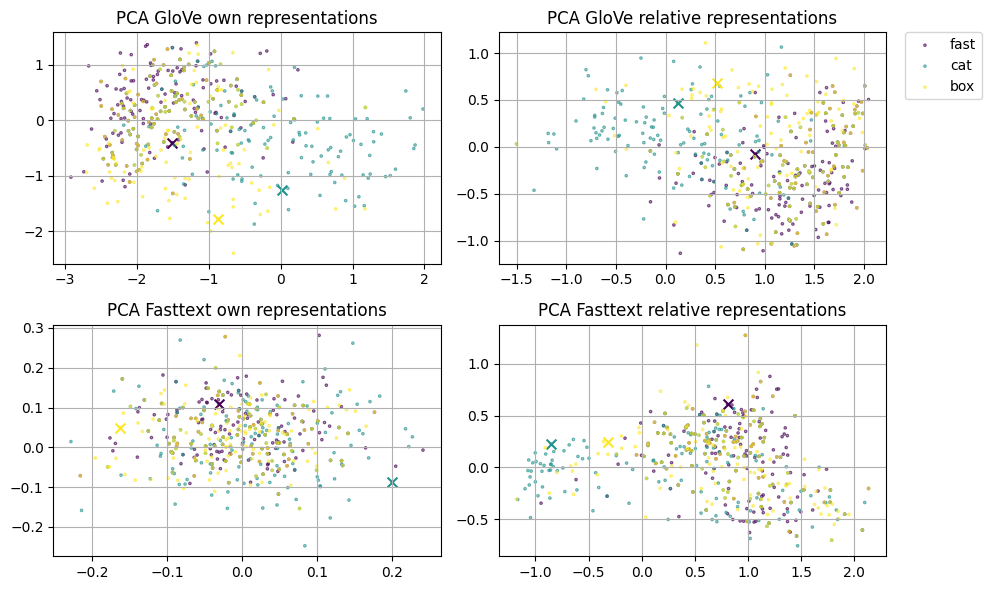

In [330]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
plt.sca(axs[0, 0])
visualize_clusters(pca_glove_own, pca_words, name=f'PCA GloVe own representations')
plt.sca(axs[1, 0])
visualize_clusters(pca_fasttext_own, pca_words, name= f'PCA Fasttext own representations')
plt.sca(axs[0, 1])
visualize_clusters(pca_glove_relative, pca_words, name=f'PCA GloVe relative representations')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.sca(axs[1, 1])
visualize_clusters(pca_fasttext_relative, pca_words, name=f'PCA Fasttext relative representations')
plt.tight_layout()
plt.show()

**5. We now repeat the process, but use the clusters as found in each space:**

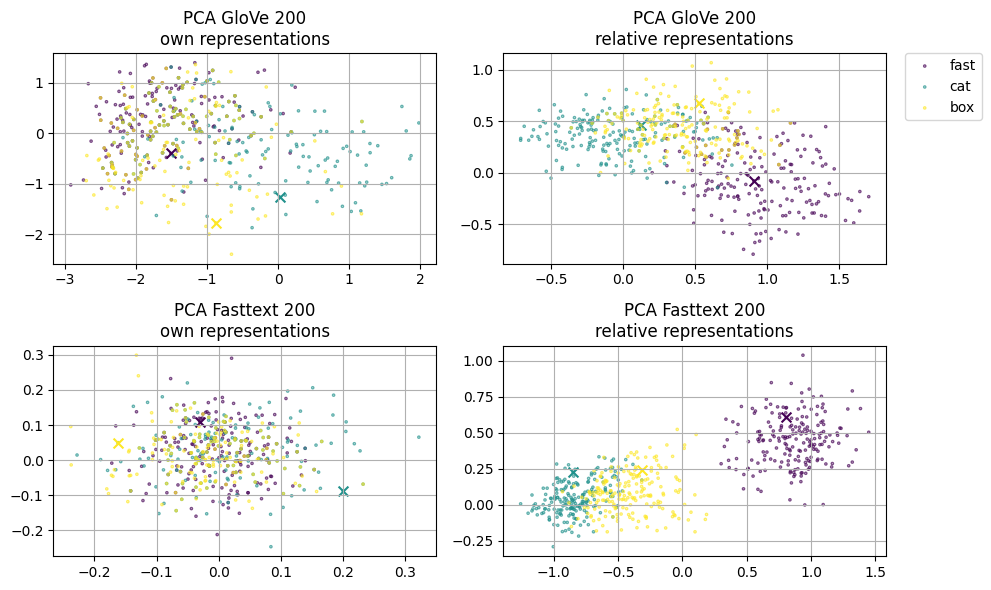

In [331]:
nearest_neighbors_glove_own = create_clusters(centers_o_rep_glove, embeddings=own_reps_glove, n_neighbors=n_points_visualisation)
nearest_neighbors_glove_relative = create_clusters(centers_rel_rep_glove, embeddings=rel_reps_glove, n_neighbors=n_points_visualisation)
nearest_neighbors_fasttext_own = create_clusters(centers_o_rep_fasttext, embeddings=own_reps_fasttext, n_neighbors=n_points_visualisation)
nearest_neighbors_fasttext_relative = create_clusters(centers_rel_rep_fasttext, embeddings=rel_reps_fasttext, n_neighbors=n_points_visualisation)

pca_glove_own = do_pca(nearest_neighbors_glove_own, embeddings=own_reps_glove)
pca_glove_relative = do_pca(nearest_neighbors_glove_relative, embeddings=rel_reps_glove)
pca_fasttext_own = do_pca(nearest_neighbors_fasttext_own, embeddings=rel_reps_fasttext)
pca_fasttext_relative = do_pca(nearest_neighbors_fasttext_relative, embeddings=rel_reps_fasttext)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
plt.sca(axs[0, 0])
visualize_clusters(pca_glove_own, pca_words, name=f'PCA GloVe {n_points_visualisation}\nown representations')
plt.sca(axs[1, 0])
visualize_clusters(pca_fasttext_own, pca_words, name= f'PCA Fasttext {n_points_visualisation}\nown representations')
plt.sca(axs[0, 1])
visualize_clusters(pca_glove_relative, pca_words, name=f'PCA GloVe {n_points_visualisation}\nrelative representations')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.sca(axs[1, 1])
visualize_clusters(pca_fasttext_relative, pca_words, name=f'PCA Fasttext {n_points_visualisation}\nrelative representations')
plt.tight_layout()
plt.show()

### Exercise 4 Similarity metrics

In order to show that the relative representations of the GloVe and Fasttext vectors are more similar than their absolute embeddings we will compare the mean reciprocal rank and cossine similarity between the two across all ~20000 word embeddings. Due to the computational cost of comparing every word with every other word across every embedding, we will only use the K=10 nearest neighbors of each word when calculating the metrics. 

**1. Look up the mean reciprocal rank metric and implement a function that calculates it.**
- https://www.evidentlyai.com/ranking-metrics/mean-reciprocal-rank-mrr

In [334]:
def mean_reciprocal_rank(query_vector, matrix):
    """
    Calculate the Mean Reciprocal Rank (MRR) given a query vector and a matrix.
    
    Parameters:
    query_vector (np.array): A vector representing the query.
    matrix (np.array): A matrix where each row represents a document.
    
    Returns:
    float: The MRR score.
    """
    # Compute relevance scores as dot products between the query_vector and each row in the matrix
    relevance_scores = np.dot(matrix, query_vector)
    
    # Get the ranks of the documents sorted by relevance (highest relevance first)
    sorted_indices = np.argsort(relevance_scores)[::-1]
    
    # Find the rank of the first relevant document
    first_relevant_rank = np.where(sorted_indices == 0)[0][0] + 1  # Adding 1 to make rank 1-based
    
    # Calculate the reciprocal rank
    reciprocal_rank = 1 / first_relevant_rank
    
    return reciprocal_rank

**2. Prepare the K=10 nearest neighbour models for each embedding type**

In [335]:
K = 10
knn_rel_glove = NearestNeighbors(n_neighbors=K)
knn_rel_glove.fit(rel_reps_glove)
nearest_neighbors_rel_glove = knn_rel_glove.kneighbors(rel_reps_glove, return_distance=False)

In [336]:
knn_rel_fasttext = NearestNeighbors(n_neighbors=K)
knn_rel_fasttext.fit(rel_reps_fasttext)
nearest_neighbors_rel_fasttext = knn_rel_fasttext.kneighbors(rel_reps_fasttext, return_distance=False)

In [337]:
knn_own_glove = NearestNeighbors(n_neighbors=K)
knn_own_glove.fit(own_reps_glove)
nearest_neighbors_own_glove = knn_own_glove.kneighbors(own_reps_glove, return_distance=False)

In [338]:
knn_own_fasttext = NearestNeighbors(n_neighbors=K)
knn_own_fasttext.fit(own_reps_fasttext)
nearest_neighbors_own_fasttext = knn_own_fasttext.kneighbors(own_reps_fasttext, return_distance=False)

**3. Now we need a function which loops across each KNN object and each representation twice in order to calculate the metrics for every possible combination**
*We are calculating the average of the metric across every word*

In [339]:
def compute_knn_results(NNs, reps, names_knn, verbose=True):
    """
    Looping across all combinations of nearest neighbor objects and representations, this function
    calculates the average Mean Reciprocal Rank (MRR) and cosine similarity between the top K neighbors
    of every word in a representation in each representation according to every KNN object.
    :param NNs: nearest neighbor objects
    :param reps: matrix of vector representations of all words
    :param names_knn: names of the NN objects
    :param verbose: to print or not to print, that is the question
    :return: result_rows: list of results containing the names of the objects used and the scores
    """
    
    result_rows = []

    for i_knn, knn in tqdm(enumerate(NNs), desc="KNN", total=len(names_knn)):
        for i_repr_1, repr_1 in tqdm(enumerate(reps), desc="Representation 1", total=len(names_knn)):
            for i_repr_2, repr_2 in tqdm(enumerate(reps), desc="Representation 2", total=len(names_knn)):
                temp_cossim, temp_mrr = [], []
                for i_vect, vector in enumerate(repr_1):
                    neighbors = knn[i_vect]
                    vector_subset = repr_2[neighbors]

                    cossim = cosine_similarity(vector, vector_subset).max()
                    mrr = mean_reciprocal_rank(vector, vector_subset)
                    temp_cossim.append(cossim)
                    temp_mrr.append(mrr)
                
                result_rows.append([
                    names_knn[i_knn], 
                    names_knn[i_repr_1], 
                    names_knn[i_repr_2], 
                    np.mean(temp_cossim), 
                    np.mean(temp_mrr),
                ])
    if verbose:
        for row in result_rows:
            print(f"Neighbors in {row[2]} according to KNN {row[0]}, with vectors from {row[1]} has Cossim {row[3]:.2f} and MRR {row[4]:.2f}")
    return result_rows

In [340]:
result_own = compute_knn_results(
    NNs=[nearest_neighbors_own_glove, nearest_neighbors_own_fasttext],
    reps=[own_reps_glove, own_reps_fasttext],
    names_knn = ["GRR", "FRR"]
)

KNN:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Neighbors in GRR according to KNN GRR, with vectors from GRR has Cossim 1.00 and MRR 1.00
Neighbors in FRR according to KNN GRR, with vectors from GRR has Cossim 0.08 and MRR 0.29
Neighbors in GRR according to KNN GRR, with vectors from FRR has Cossim 0.07 and MRR 0.29
Neighbors in FRR according to KNN GRR, with vectors from FRR has Cossim 1.00 and MRR 1.00
Neighbors in GRR according to KNN FRR, with vectors from GRR has Cossim 1.00 and MRR 1.00
Neighbors in FRR according to KNN FRR, with vectors from GRR has Cossim 0.07 and MRR 0.29
Neighbors in GRR according to KNN FRR, with vectors from FRR has Cossim 0.08 and MRR 0.28
Neighbors in FRR according to KNN FRR, with vectors from FRR has Cossim 1.00 and MRR 1.00


In [341]:
result_rel = compute_knn_results(
    NNs=[nearest_neighbors_rel_glove, nearest_neighbors_rel_fasttext],
    reps=[rel_reps_glove, rel_reps_fasttext],
    names_knn = ["GRR", "FRR"]
)

KNN:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Neighbors in GRR according to KNN GRR, with vectors from GRR has Cossim 1.00 and MRR 0.97
Neighbors in FRR according to KNN GRR, with vectors from GRR has Cossim 0.55 and MRR 0.82
Neighbors in GRR according to KNN GRR, with vectors from FRR has Cossim 0.54 and MRR 0.85
Neighbors in FRR according to KNN GRR, with vectors from FRR has Cossim 1.00 and MRR 0.95
Neighbors in GRR according to KNN FRR, with vectors from GRR has Cossim 1.00 and MRR 0.97
Neighbors in FRR according to KNN FRR, with vectors from GRR has Cossim 0.54 and MRR 0.89
Neighbors in GRR according to KNN FRR, with vectors from FRR has Cossim 0.54 and MRR 0.81
Neighbors in FRR according to KNN FRR, with vectors from FRR has Cossim 1.00 and MRR 0.93


**4. Interpret the results. How much more similar are the relative representations to the absolute ones?**